In [1]:
import numpy as np

from finquant.portfolio import *
from finquant.moving_average import compute_ma, ema

import pandas as pd
import datetime

import yfinance as yf

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import black_litterman, risk_models
from pypfopt.black_litterman import BlackLittermanModel
from pypfopt import expected_returns
from pypfopt import risk_models
from pypfopt import EfficientFrontier, objective_functions

import riskfolio.Portfolio as pf
from sklearn.metrics import mean_squared_error

import matplotlib as plt
import matplotlib.pyplot as pyplt

import statsmodels .api  as  sm 
from sklearn.linear_model  import  LinearRegression
import cvxpy  as  cv
from scipy.stats import norm

import quantstats as qs

In [2]:
df_health = pd.read_csv('tick_score_Health Care.csv')
df_tech = pd.read_csv('tick_score_Technology.csv')
df_durable = pd.read_csv('tick_score_Consumer Durables.csv')
df_nondurable = pd.read_csv('tick_score_Consumer Non-Durables.csv')
df_capital = pd.read_csv('tick_score_Capital Goods.csv')
df_transport = pd.read_csv('tick_score_Transportation.csv')
df_util = pd.read_csv('tick_score_Public Utilities.csv')
df_services = pd.read_csv('tick_score_Consumer Services.csv')
df_energy = pd.read_csv('tick_score_Energy.csv')
df_finance = pd.read_csv('tick_score_Finance.csv')
df_basics = pd.read_csv('tick_score_Basic Industries.csv')


frames = [df_finance, df_capital, df_durable, df_energy, df_health, df_nondurable, df_services, df_tech, df_services, df_util, df_basics]
df = pd.concat(frames)
df = df.drop_duplicates(subset=['Unnamed: 0'], keep='last')
df = df.set_index("Unnamed: 0")

percentile = np.percentile(df['Score'], 90)
mu, std = norm.fit(df['Score'])
roc = std / 3
aplus = df[df['Score'] > percentile - (roc*2)]
#aplus = df[df['Score'] > mu + (roc*6)]
tickers = list(aplus.index)
#tickers.remove("ANET")
#tickers.remove("LUMN")

In [3]:
start = "2007-01-01"
end = "2010-01-01"
future_end = "2020-01-01"

In [4]:
# Tickers of assets
assets = list(tickers)
assets.sort()

In [5]:
data = yf.download(assets, start = start, end = end, threads = False)
data = data.loc[:,('Adj Close', slice(None))]
data.columns = assets

market_data = yf.download("^GSPC", start = start, end=end, threads = False)
market_data = market_data.loc[:,('Adj Close')]

[*********************100%***********************]  104 of 104 completed

1 Failed download:
- ANET: Data doesn't exist for startDate = 1167609600, endDate = 1262304000
[*********************100%***********************]  1 of 1 completed


In [6]:
port_diff = data[assets].pct_change()[1:].dropna(axis=1)
mkt_diff = market_data.pct_change().dropna()

In [7]:
assets = list(port_diff.columns)

In [8]:
pf = build_portfolio(names=assets, start_date = start, end_date = end, data_api="yfinance")
opt_w, opt_res = pf.mc_optimisation(num_trials=5000)      # Monte Carlo weights and results
weights = pd.DataFrame(opt_w.loc["Max Sharpe Ratio"])
weights = weights.reset_index()
weights.columns = ["Name", "Allocation"]
pf2 = build_portfolio(names=assets, start_date = start, end_date = end, data_api="yfinance", pf_allocation = weights)
MC_Weights = weights.set_index("Name")

[*********************100%***********************]  102 of 102 completed


\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


[*********************100%***********************]  102 of 102 completed


In [9]:
# Time for CAPM
x = mkt_diff.values 
x = sm.add_constant(x)
print(len(x))
print(len(port_diff))
Beta_1  =  [] 
for i in assets:
    try:
        y_i =  port_diff[i].values 
        mod =  sm.OLS(y_i, x) 
        res =  mod.fit() 
        Beta_1.append(res.params[1])
    except:pass
Beta_1 = np.matrix(Beta_1)

# Using scikit learn 
y = port_diff.values 
x = mkt_diff.values
lst = []
for i in mkt_diff.values:
    lst.append([i])

x = lst
reg = LinearRegression().fit(x, y)
Beta_2 = np.matrix(reg.coef_).T

# Combining both betas to show them 
B1 = pd.DataFrame(Beta_1.T, index = list(port_diff.columns), columns = ['Beta_1']) 
B2 = pd.DataFrame(Beta_2.T, index = list(port_diff.columns), columns = ['Beta_2'])

B1_B2 = pd.concat([B1, B2], axis = 1)


################################################## ####################### 
# Calculating the vector of means and the matrix of covariances from 
# the CAPM model 
########### ################################################## ###########

Sigma_rm = np.matrix(np.var(mkt_diff, ddof = 1))

x = mkt_diff.values 
x = sm.add_constant(x)

mu_F_1 = []
Sigma_e_1 = []
for i in assets:
    try:
        y_i = port_diff[i].values
        mod = sm.OLS(y_i, x)
        res = mod.fit()
        error = np.matrix(y_i) - np.matrix(res.predict(x))
        mu_F_1.append(np.mean(res.predict(x), axis = 0))
        Sigma_e_1.append(np.asscalar(np.var(error.T, ddof = 1, axis = 0)))
    except:pass

mu_F_1 = np.matrix(mu_F_1)
Sigma_e_1 = np.diag(Sigma_e_1)
Sigma_F_1 = Beta_2.T * Sigma_rm *  Beta_2 + Sigma_e_1

x = mkt_diff.values
lst = []
for i in mkt_diff.values:
    lst.append([i])

x = lst
error_2 = y - reg.predict(x)

mu_F_2 = np.matrix(np.mean(reg.predict(x), axis = 0))
Sigma_e_2 = np.diag(np.var(error_2, ddof = 1, axis = 0))
Sigma_F_2 = Beta_2.T * Sigma_rm *  Beta_2 + Sigma_e_2

################################################## ###################### 
# Calculating optimal portfolios with historical estimates 
# and CAPM estimates 
############# ################################################## #########

# Defining the optimization function 
def Max_Sharpe(mu, Sigma):
    w = cv.Variable((mu.shape[1], 1))
    k = cv.Variable(1)
    rf = cv.Parameter(nonneg=True)
    rf.value=0
    #defining the problem, objective function and    
    constraints = [(mu - rf)*w == 1,
                   w >= 1e-10,
                   k >= 1e-10,
                   cv.sum(w) == k]
    prob = cv.Problem(cv.Minimize(cv.quad_form(w, Sigma)), constraints)
    #solving the problem
    prob.solve(solver=cv.ECOS)

    return np.matrix(w.value/k.value)

755
755


<ipython-input-9-9c82cfe8aaf1>:53: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  Sigma_e_1.append(np.asscalar(np.var(error.T, ddof = 1, axis = 0)))


In [10]:
mu = np.matrix(np.mean(port_diff.values, axis = 0))
Sigma = np.cov(port_diff.values.T)

w1 = Max_Sharpe(mu, Sigma)
w2 = Max_Sharpe(mu_F_2, Sigma_F_2)



Historical_Weights = pd.DataFrame(w1, index = assets, columns = ['Historical'])
CAPM_Weights = pd.DataFrame(w2, index = assets, columns = ['CAPM'])


\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\cvxpy\expressions\expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 1 times so far.

  warnings.warn(msg, UserWarning)
\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\cvxpy\expressions\expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2 times so far.

  warnings.war

In [11]:
# Fama Three
three_factor = pd.read_csv('FF_three.csv', index_col=0, header=0)/100
three_factor = three_factor.loc[start: end][:-1]
x = three_factor[['Mkt-RF', 'SMB', 'HML']].values
y = port_diff.values
reg = LinearRegression().fit(x, y)
B = np.matrix(reg.coef_).T


Sigma_F = np.cov(x.T)
error = y - reg.predict(x)
Sigma_e = np.diag(np.var(error, ddof = 1, axis = 0))

mu_fama = np.matrix(np.mean(reg.predict(x), axis = 0))
Sigma_fama = B.T * Sigma_F *  B + Sigma_e_2


w_fama_three = Max_Sharpe(mu_fama, Sigma_fama)

F3_Weights = pd.DataFrame(w_fama_three, index = assets, columns = ['Fama Three'])

\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\cvxpy\expressions\expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3 times so far.

  warnings.warn(msg, UserWarning)


In [12]:
five_factor = pd.read_csv('FF_five.csv', index_col=0, header=0)/100
five_factor = five_factor.loc[start: end][:-1]
x = five_factor[['Mkt-RF', 'SMB', 'HML', 'RMW','CMA']].values
y = port_diff.values
reg = LinearRegression().fit(x, y)
B = np.matrix(reg.coef_).T

Sigma_F = np.cov(x.T)
error = y - reg.predict(x)
Sigma_e = np.diag(np.var(error, ddof = 1, axis = 0))
mu_fama = np.matrix(np.mean(reg.predict(x), axis = 0))
Sigma_fama = B.T * Sigma_F *  B + Sigma_e_2
w_fama_five = Max_Sharpe(mu_fama, Sigma_fama)


F5_Weights = pd.DataFrame(w_fama_five, index = assets, columns = ['Fama Five'])


\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\cvxpy\expressions\expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 4 times so far.

  warnings.warn(msg, UserWarning)


In [13]:
# Black Litterman

S = risk_models.CovarianceShrinkage(data[assets]).ledoit_wolf()
delta = black_litterman.market_implied_risk_aversion(market_data)
display(delta)


-0.6140537262602036

In [14]:
comparisons = ["^GSPC", "WFIVX", "PRWAX", "SWPPX"]
sp_500 = yf.download(tickers=comparisons, start=start, end="2021-01-01", threads = False)
sp_500 = sp_500.loc[:,('Close')]
sp_500_total_cum_return = ((sp_500.iloc[-1] - sp_500.iloc[0]) / sp_500.iloc[0])*100
display(sp_500_total_cum_return)
sp_500_daily = sp_500.pct_change().fillna(100)[1:]
compare_port = (sp_500_daily + 1).cumprod()
compare_port *= 100
compare_port = pd.DataFrame(compare_port)
display(compare_port)

Y_cum = data[assets].pct_change().fillna(0)[1:]
CAPM_port_ret = data[assets].pct_change().fillna(0)[1:]
F3_port_ret = data[assets].pct_change().fillna(0)[1:]
F5_port_ret = data[assets].pct_change().fillna(0)[1:]
MC_port_ret = data[assets].pct_change().fillna(0)[1:]

display(F3_port_ret)
display(F5_port_ret)
for tick in assets:
    CAPM_port_ret.loc[:,tick] = CAPM_port_ret.loc[:,tick] * CAPM_Weights.loc[tick].values
    F3_port_ret.loc[:,tick] = F3_port_ret.loc[:,tick] * F3_Weights.loc[tick].values
    F5_port_ret.loc[:,tick] = F5_port_ret.loc[:,tick] * F5_Weights.loc[tick].values
    MC_port_ret.loc[:,tick] = MC_port_ret.loc[:,tick] * MC_Weights.loc[tick].values

display(F3_port_ret)
display(F5_port_ret)

CAPM_port_ret = CAPM_port_ret.sum(axis=1)
F3_port_ret = F3_port_ret.sum(axis=1)
F5_port_ret = F5_port_ret.sum(axis=1)
MC_port_ret = MC_port_ret.sum(axis=1)
CAPM_cum_ret = (((CAPM_port_ret + 1).cumprod()) * 100)
F3_cum_ret = (((F3_port_ret + 1).cumprod()) * 100)
F5_cum_ret = (((F5_port_ret + 1).cumprod()) * 100)
MC_cum_ret = (((MC_port_ret + 1).cumprod()) * 100)

[*********************100%***********************]  4 of 4 completed


PRWAX    118.059974
SWPPX    162.311557
WFIVX    109.325553
^GSPC    165.146840
dtype: float64

PRWAX       SWPPX       WFIVX       ^GSPC
Date                                                      
2007-01-04  100.829611  100.091368  100.166524  100.122829
2007-01-05  100.063818   99.497493   99.417147   99.513623
2007-01-08  100.446712   99.771589   99.666945   99.734575
2007-01-09  100.701976   99.725905   99.666945   99.683045
2007-01-10  101.244414   99.908641   99.916734   99.876465
...                ...         ...         ...         ...
2020-12-24  215.443511  258.565555  209.408819  261.404781
2020-12-28  216.624120  260.804028  210.741041  263.684891
2020-12-29  216.751755  260.210145  207.826799  263.097565
2020-12-30  217.007026  260.621292  208.326395  263.450523
2020-12-31  218.059974  262.311557  209.325553  265.146840

[3524 rows x 4 columns]

ABB       ABT      AGCO       ALL      ALXN      AMAT  \
Date                                                                     
2007-01-04 -0.031987  0.018992 -0.022442  0.001225  0.002955  0.020630   
2007-01-05 -0.018551  0.000000 -0.010128 -0.002754 -0.006629 -0.006915   
2007-01-08  0.015948  0.003607 -0.004775  0.001380 -0.027435  0.011784   
2007-01-09 -0.003488  0.008786  0.004798 -0.005209 -0.007624  0.019058   
2007-01-10  0.001167  0.003285  0.004093 -0.002618  0.034059  0.015065   
...              ...       ...       ...       ...       ...       ...   
2009-12-24  0.005277  0.001109  0.003368  0.003985  0.003935  0.003584   
2009-12-28  0.002625  0.007017 -0.007934  0.003970 -0.000619 -0.010000   
2009-12-29  0.007330 -0.004951 -0.007075 -0.000659 -0.003303 -0.008658   
2009-12-30 -0.001040  0.005160  0.004337  0.006594  0.007664  0.023290   
2009-12-31 -0.006243 -0.010084 -0.002468 -0.016050  0.003494 -0.008535   

                 AMX       APD      ASML       AZO  ...       TRV        TS  \
Date                                                ...                       
2007-01-04 -0.000649 -0.021972  0.011079  0.008347  ... -0.008404 -0.033388   
2007-01-05 -0.031182 -0.013935  0.004464 -0.006438  ... -0.012994  0.008529   
2007-01-08  0.000223 -0.001297  0.011313  0.000168  ... -0.007441  0.010782   
2007-01-09 -0.031732 -0.002166 -0.010787  0.023223  ... -0.002500 -0.030119   
2007-01-10  0.011078  0.008103 -0.003231 -0.006496  ... -0.006552  0.045720   
...              ...       ...       ...       ...  ...       ...       ...   
2009-12-24  0.002947  0.006519  0.003773 -0.002308  ...  0.015453  0.005881   
2009-12-28 -0.007766  0.003422 -0.008097 -0.002001  ... -0.002202  0.003742   
2009-12-29  0.002327  0.007065  0.000000 -0.000752  ...  0.000803 -0.001631   
2009-12-30 -0.009287  0.000122  0.004373  0.000000  ...  0.007820  0.001867   
2009-12-31  0.000852 -0.014348 -0.010450 -0.008779  ... -0.007959 -0.006522   

                 TTC      UHAL       URI      VALE       VIV       WAT  \
Date                                                                     
2007-01-04  0.011824  0.027350 -0.016609 -0.012144 -0.004632  0.006956   
2007-01-05 -0.002922 -0.030873 -0.016889 -0.033720 -0.027918 -0.011174   
2007-01-08 -0.001883  0.003578 -0.008790  0.034897  0.005186  0.038628   
2007-01-09  0.003984 -0.034503  0.006046 -0.029154 -0.027778  0.011672   
2007-01-10 -0.002507  0.007385  0.008013  0.026773  0.003674  0.014861   
...              ...       ...       ...       ...       ...       ...   
2009-12-24  0.022381 -0.002976  0.002933  0.014020 -0.002049  0.000651   
2009-12-28  0.010713 -0.006903 -0.011696  0.003802  0.013142  0.004227   
2009-12-29  0.009447 -0.008454 -0.007890 -0.009986  0.004054  0.003723   
2009-12-30 -0.019859 -0.027851 -0.006958 -0.000348  0.015745  0.003710   
2009-12-31 -0.026316 -0.030988 -0.018018  0.010091 -0.007552 -0.004339   

                 XOM       YUM  
Date                            
2007-01-04 -0.018756 -0.002718  
2007-01-05  0.007150 -0.008688  
2007-01-08 -0.008056 -0.002406  
2007-01-09 -0.007708  0.003790  
2007-01-10 -0.015259  0.012044  
...              ...       ...  
2009-12-24  0.005860 -0.000565  
2009-12-28  0.006117 -0.006218  
2009-12-29 -0.003474  0.001706  
2009-12-30 -0.001017 -0.000284  
2009-12-31 -0.008434 -0.006816  

[755 rows x 102 columns]

ABB       ABT      AGCO       ALL      ALXN      AMAT  \
Date                                                                     
2007-01-04 -0.031987  0.018992 -0.022442  0.001225  0.002955  0.020630   
2007-01-05 -0.018551  0.000000 -0.010128 -0.002754 -0.006629 -0.006915   
2007-01-08  0.015948  0.003607 -0.004775  0.001380 -0.027435  0.011784   
2007-01-09 -0.003488  0.008786  0.004798 -0.005209 -0.007624  0.019058   
2007-01-10  0.001167  0.003285  0.004093 -0.002618  0.034059  0.015065   
...              ...       ...       ...       ...       ...       ...   
2009-12-24  0.005277  0.001109  0.003368  0.003985  0.003935  0.003584   
2009-12-28  0.002625  0.007017 -0.007934  0.003970 -0.000619 -0.010000   
2009-12-29  0.007330 -0.004951 -0.007075 -0.000659 -0.003303 -0.008658   
2009-12-30 -0.001040  0.005160  0.004337  0.006594  0.007664  0.023290   
2009-12-31 -0.006243 -0.010084 -0.002468 -0.016050  0.003494 -0.008535   

                 AMX       APD      ASML       AZO  ...       TRV        TS  \
Date                                                ...                       
2007-01-04 -0.000649 -0.021972  0.011079  0.008347  ... -0.008404 -0.033388   
2007-01-05 -0.031182 -0.013935  0.004464 -0.006438  ... -0.012994  0.008529   
2007-01-08  0.000223 -0.001297  0.011313  0.000168  ... -0.007441  0.010782   
2007-01-09 -0.031732 -0.002166 -0.010787  0.023223  ... -0.002500 -0.030119   
2007-01-10  0.011078  0.008103 -0.003231 -0.006496  ... -0.006552  0.045720   
...              ...       ...       ...       ...  ...       ...       ...   
2009-12-24  0.002947  0.006519  0.003773 -0.002308  ...  0.015453  0.005881   
2009-12-28 -0.007766  0.003422 -0.008097 -0.002001  ... -0.002202  0.003742   
2009-12-29  0.002327  0.007065  0.000000 -0.000752  ...  0.000803 -0.001631   
2009-12-30 -0.009287  0.000122  0.004373  0.000000  ...  0.007820  0.001867   
2009-12-31  0.000852 -0.014348 -0.010450 -0.008779  ... -0.007959 -0.006522   

                 TTC      UHAL       URI      VALE       VIV       WAT  \
Date                                                                     
2007-01-04  0.011824  0.027350 -0.016609 -0.012144 -0.004632  0.006956   
2007-01-05 -0.002922 -0.030873 -0.016889 -0.033720 -0.027918 -0.011174   
2007-01-08 -0.001883  0.003578 -0.008790  0.034897  0.005186  0.038628   
2007-01-09  0.003984 -0.034503  0.006046 -0.029154 -0.027778  0.011672   
2007-01-10 -0.002507  0.007385  0.008013  0.026773  0.003674  0.014861   
...              ...       ...       ...       ...       ...       ...   
2009-12-24  0.022381 -0.002976  0.002933  0.014020 -0.002049  0.000651   
2009-12-28  0.010713 -0.006903 -0.011696  0.003802  0.013142  0.004227   
2009-12-29  0.009447 -0.008454 -0.007890 -0.009986  0.004054  0.003723   
2009-12-30 -0.019859 -0.027851 -0.006958 -0.000348  0.015745  0.003710   
2009-12-31 -0.026316 -0.030988 -0.018018  0.010091 -0.007552 -0.004339   

                 XOM       YUM  
Date                            
2007-01-04 -0.018756 -0.002718  
2007-01-05  0.007150 -0.008688  
2007-01-08 -0.008056 -0.002406  
2007-01-09 -0.007708  0.003790  
2007-01-10 -0.015259  0.012044  
...              ...       ...  
2009-12-24  0.005860 -0.000565  
2009-12-28  0.006117 -0.006218  
2009-12-29 -0.003474  0.001706  
2009-12-30 -0.001017 -0.000284  
2009-12-31 -0.008434 -0.006816  

[755 rows x 102 columns]

ABB       ABT      AGCO           ALL      ALXN  \
Date                                                               
2007-01-04 -0.000868  0.000093 -0.000288  1.002770e-13  0.000163   
2007-01-05 -0.000504  0.000000 -0.000130 -2.253437e-13 -0.000366   
2007-01-08  0.000433  0.000018 -0.000061  1.129558e-13 -0.001514   
2007-01-09 -0.000095  0.000043  0.000062 -4.262664e-13 -0.000421   
2007-01-10  0.000032  0.000016  0.000053 -2.142560e-13  0.001880   
...              ...       ...       ...           ...       ...   
2009-12-24  0.000143  0.000005  0.000043  3.261358e-13  0.000217   
2009-12-28  0.000071  0.000034 -0.000102  3.248544e-13 -0.000034   
2009-12-29  0.000199 -0.000024 -0.000091 -5.394474e-14 -0.000182   
2009-12-30 -0.000028  0.000025  0.000056  5.396323e-13  0.000423   
2009-12-31 -0.000170 -0.000049 -0.000032 -1.313390e-12  0.000193   

                    AMAT       AMX       APD      ASML       AZO  ...  \
Date                                                              ...   
2007-01-04  3.443302e-12 -0.000004 -0.000490  0.000223  0.000246  ...   
2007-01-05 -1.154224e-12 -0.000214 -0.000311  0.000090 -0.000190  ...   
2007-01-08  1.966894e-12  0.000002 -0.000029  0.000228  0.000005  ...   
2007-01-09  3.180937e-12 -0.000218 -0.000048 -0.000218  0.000684  ...   
2007-01-10  2.514535e-12  0.000076  0.000181 -0.000065 -0.000191  ...   
...                  ...       ...       ...       ...       ...  ...   
2009-12-24  5.982412e-13  0.000020  0.000146  0.000076 -0.000068  ...   
2009-12-28 -1.669113e-12 -0.000053  0.000076 -0.000163 -0.000059  ...   
2009-12-29 -1.445119e-12  0.000016  0.000158  0.000000 -0.000022  ...   
2009-12-30  3.887323e-12 -0.000064  0.000003  0.000088  0.000000  ...   
2009-12-31 -1.424591e-12  0.000006 -0.000320 -0.000211 -0.000259  ...   

                     TRV        TS       TTC          UHAL           URI  \
Date                                                                       
2007-01-04 -9.836920e-13 -0.000060  0.000061  2.716064e-12 -1.729290e-12   
2007-01-05 -1.521066e-12  0.000015 -0.000015 -3.065854e-12 -1.758489e-12   
2007-01-08 -8.710040e-13  0.000020 -0.000010  3.553099e-13 -9.151564e-13   
2007-01-09 -2.926044e-13 -0.000055  0.000020 -3.426346e-12  6.294982e-13   
2007-01-10 -7.669668e-13  0.000083 -0.000013  7.334302e-13  8.342922e-13   
...                  ...       ...       ...           ...           ...   
2009-12-24  1.808918e-12  0.000011  0.000115 -2.955617e-13  3.053421e-13   
2009-12-28 -2.577990e-13  0.000007  0.000055 -6.855164e-13 -1.217768e-12   
2009-12-29  9.398409e-14 -0.000003  0.000049 -8.395140e-13 -8.214530e-13   
2009-12-30  9.153922e-13  0.000003 -0.000102 -2.765835e-12 -7.244946e-13   
2009-12-31 -9.316018e-13 -0.000012 -0.000135 -3.077341e-12 -1.876016e-12   

                VALE       VIV       WAT           XOM       YUM  
Date                                                              
2007-01-04 -0.000482 -0.000052  0.000152 -3.936943e-12 -0.000057  
2007-01-05 -0.001338 -0.000311 -0.000244  1.500889e-12 -0.000182  
2007-01-08  0.001384  0.000058  0.000843 -1.690914e-12 -0.000050  
2007-01-09 -0.001157 -0.000310  0.000255 -1.618018e-12  0.000079  
2007-01-10  0.001062  0.000041  0.000325 -3.202848e-12  0.000253  
...              ...       ...       ...           ...       ...  
2009-12-24  0.000556 -0.000023  0.000014  1.230020e-12 -0.000012  
2009-12-28  0.000151  0.000147  0.000092  1.283989e-12 -0.000130  
2009-12-29 -0.000396  0.000045  0.000081 -7.292972e-13  0.000036  
2009-12-30 -0.000014  0.000176  0.000081 -2.134210e-13 -0.000006  
2009-12-31  0.000400 -0.000084 -0.000095 -1.770266e-12 -0.000143  

[755 rows x 102 columns]

ABB       ABT      AGCO           ALL      ALXN  \
Date                                                               
2007-01-04 -0.000844  0.000172 -0.000276  6.802712e-13  0.000168   
2007-01-05 -0.000489  0.000000 -0.000125 -1.528714e-12 -0.000376   
2007-01-08  0.000421  0.000033 -0.000059  7.662833e-13 -0.001556   
2007-01-09 -0.000092  0.000080  0.000059 -2.891757e-12 -0.000432   
2007-01-10  0.000031  0.000030  0.000050 -1.453496e-12  0.001932   
...              ...       ...       ...           ...       ...   
2009-12-24  0.000139  0.000010  0.000041  2.212479e-12  0.000223   
2009-12-28  0.000069  0.000064 -0.000098  2.203786e-12 -0.000035   
2009-12-29  0.000193 -0.000045 -0.000087 -3.659568e-13 -0.000187   
2009-12-30 -0.000027  0.000047  0.000053  3.660822e-12  0.000435   
2009-12-31 -0.000165 -0.000092 -0.000030 -8.909935e-12  0.000198   

                    AMAT       AMX       APD      ASML       AZO  ...  \
Date                                                              ...   
2007-01-04  4.327706e-11 -0.000004 -0.000579  0.000198  0.000259  ...   
2007-01-05 -1.450684e-11 -0.000206 -0.000367  0.000080 -0.000200  ...   
2007-01-08  2.472087e-11  0.000001 -0.000034  0.000202  0.000005  ...   
2007-01-09  3.997953e-11 -0.000210 -0.000057 -0.000192  0.000721  ...   
2007-01-10  3.160388e-11  0.000073  0.000214 -0.000058 -0.000202  ...   
...                  ...       ...       ...       ...       ...  ...   
2009-12-24  7.518982e-12  0.000019  0.000172  0.000067 -0.000072  ...   
2009-12-28 -2.097821e-11 -0.000051  0.000090 -0.000144 -0.000062  ...   
2009-12-29 -1.816295e-11  0.000015  0.000186  0.000000 -0.000023  ...   
2009-12-30  4.885773e-11 -0.000061  0.000003  0.000078  0.000000  ...   
2009-12-31 -1.790494e-11  0.000006 -0.000378 -0.000186 -0.000273  ...   

                     TRV        TS       TTC          UHAL           URI  \
Date                                                                       
2007-01-04 -8.852801e-12 -0.000114  0.000046  5.217382e-11 -1.524081e-11   
2007-01-05 -1.368893e-11  0.000029 -0.000011 -5.889305e-11 -1.549815e-11   
2007-01-08 -7.838657e-12  0.000037 -0.000007  6.825272e-12 -8.065581e-12   
2007-01-09 -2.633313e-12 -0.000103  0.000016 -6.581789e-11  5.547979e-12   
2007-01-10 -6.902368e-12  0.000156 -0.000010  1.408872e-11  7.352898e-12   
...                  ...       ...       ...           ...           ...   
2009-12-24  1.627947e-11  0.000020  0.000087 -5.677547e-12  2.691082e-12   
2009-12-28 -2.320079e-12  0.000013  0.000042 -1.316832e-11 -1.073260e-11   
2009-12-29  8.458160e-13 -0.000006  0.000037 -1.612652e-11 -7.239741e-12   
2009-12-30  8.238132e-12  0.000006 -0.000078 -5.312990e-11 -6.385215e-12   
2009-12-31 -8.384011e-12 -0.000022 -0.000103 -5.911371e-11 -1.653396e-11   

                VALE       VIV       WAT           XOM       YUM  
Date                                                              
2007-01-04 -0.000506 -0.000046  0.000132 -3.350456e-11 -0.000055  
2007-01-05 -0.001406 -0.000279 -0.000212  1.277302e-11 -0.000176  
2007-01-08  0.001455  0.000052  0.000734 -1.439018e-11 -0.000049  
2007-01-09 -0.001216 -0.000277  0.000222 -1.376981e-11  0.000077  
2007-01-10  0.001116  0.000037  0.000283 -2.725719e-11  0.000244  
...              ...       ...       ...           ...       ...  
2009-12-24  0.000585 -0.000020  0.000012  1.046784e-11 -0.000011  
2009-12-28  0.000159  0.000131  0.000080  1.092713e-11 -0.000126  
2009-12-29 -0.000416  0.000040  0.000071 -6.206538e-12  0.000035  
2009-12-30 -0.000015  0.000157  0.000071 -1.816276e-12 -0.000006  
2009-12-31  0.000421 -0.000075 -0.000082 -1.506549e-11 -0.000138  

[755 rows x 102 columns]

Date
2007-01-04     99.736953
2007-01-05     99.028832
2007-01-08     99.568325
2007-01-09     99.691139
2007-01-10    100.437051
                 ...    
2009-12-24    174.268923
2009-12-28    174.143924
2009-12-29    174.126921
2009-12-30    174.266656
2009-12-31    173.161353
Length: 755, dtype: float64

0           1           2           3
Date                                                      
2007-01-04  100.154840   99.736953   99.678066   99.930082
2007-01-05   99.390364   99.028832   98.967753   99.022090
2007-01-08   98.227307   99.568325   99.519811   99.344326
2007-01-09   98.098026   99.691139   99.635247   99.216248
2007-01-10  100.510466  100.437051  100.376095  100.081440
...                ...         ...         ...         ...
2009-12-24  259.639042  174.268923  174.939914  128.915855
2009-12-28  259.061098  174.143924  174.830957  128.761928
2009-12-29  258.219874  174.126921  174.785331  128.612530
2009-12-30  259.163417  174.266656  174.930843  128.742160
2009-12-31  259.943633  173.161353  173.857570  127.662171

[755 rows x 4 columns]

<AxesSubplot:xlabel='Date'>

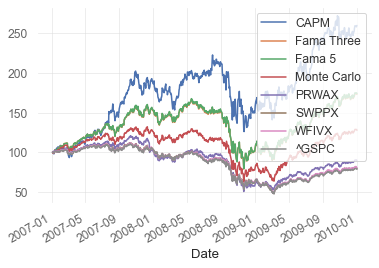

In [15]:
display(F3_cum_ret)
pfcr = pd.concat([CAPM_cum_ret, F3_cum_ret, F5_cum_ret, MC_cum_ret], axis=1)
display(pfcr)
pfcr.columns = ["CAPM", "Fama Three", "Fama 5", "Monte Carlo"]
pfcr = pd.DataFrame(pfcr)
newdf = pfcr.join(compare_port)
newdf.plot()

In [71]:
data = yf.download(assets, start = start, end = end, threads = False)
data = data.loc[:,('Close', slice(None))]
data.columns = assets

CAPM_port_ret = data
F3_port_ret = data
F5_port_ret = data
MC_port_ret = data

for tick in assets:
    try:CAPM_port_ret.loc[:,tick] = data.loc[:,tick] * CAPM_Weights.loc[tick].values
    except:pass
    try:F3_port_ret.loc[:,tick] = data.loc[:,tick] * F3_Weights.loc[tick].values
    except:pass
    try:F5_port_ret.loc[:,tick] = data.loc[:,tick] * F5_Weights.loc[tick].values
    except:pass
    try:MC_port_ret.loc[:,tick] = data.loc[:,tick] * MC_Weights.loc[tick].values
    except:pass

#BL_port_ret = BL_port_ret.mean(axis=1)
#CAPM_port_ret = CAPM_port_ret.mean(axis=1)
#F3_port_ret = F3_port_ret.mean(axis=1)
#F5_port_ret = F5_port_ret.mean(axis=1)
#MC_port_ret = MC_port_ret.mean(axis=1)
CAPM_port_ret = pd.DataFrame(CAPM_port_ret.mean(axis=1))
F3_port_ret = pd.DataFrame(F3_port_ret.mean(axis=1))
F5_port_ret = pd.DataFrame(F5_port_ret.mean(axis=1))
MC_port_ret = pd.DataFrame(MC_port_ret.mean(axis=1))

CAPM_port_ret.columns = ["Close"]
F3_port_ret.columns = ["Close"]
F5_port_ret.columns = ["Close"]
MC_port_ret.columns = ["Close"]


CAPM_diff = pd.DataFrame(CAPM_port_ret.pct_change().dropna())
F3_diff = pd.DataFrame(F3_port_ret.pct_change().dropna())
F5_diff = pd.DataFrame(F5_port_ret.pct_change().dropna())
MC_diff = pd.DataFrame(MC_port_ret.pct_change().dropna())

CAPM_diff.columns = ["Close"]
F3_diff.columns = ["Close"]
F5_diff.columns = ["Close"]
MC_diff.columns = ["Close"]

[*********************100%***********************]  102 of 102 completed


In [23]:
'''CAPM_Weights = CAPM_Weights.reset_index()
CAPM_Weights.columns = ["Name", "Allocation"]'''
print(CAPM_Weights)
df_pf_CAPM = build_portfolio(names=list(CAPM_Weights["Name"]), start_date = start, end_date = end, data_api="yfinance", pf_allocation = CAPM_Weights)
df_pf_CAPM.freq = 755
df_pf_CAPM.risk_free_rate = 1.66
print(f"Sharpe Ratio: {df_pf_CAPM.comp_sharpe()}")

     Name    Allocation
0     ABB  4.564891e-10
1     ABT  3.105730e-09
2    AGCO  5.802194e-10
3     ALL  1.842980e-10
4    ALXN  5.314258e-01
..    ...           ...
97   VALE  5.747462e-02
98    VIV  9.624500e-10
99    WAT  3.702578e-09
100   XOM  4.176843e-10
101   YUM  1.022883e-09

[102 rows x 2 columns]
[*********************100%***********************]  102 of 102 completed
Sharpe Ratio: -0.6781364438206134


In [25]:
'''F3_Weights = F3_Weights.reset_index()
F3_Weights.columns = ["Name", "Allocation"]'''
print(F3_Weights)
pf = build_portfolio(names=list(F3_Weights["Name"]), start_date = start, end_date = end, data_api="yfinance", pf_allocation = F3_Weights)
pf.freq = 755
pf.risk_free_rate = 1.66
print(f"Sharpe Ratio: {pf.comp_sharpe()}")

     index  Name    Allocation
0        0   ABB  2.715072e-02
1        1   ABT  4.874481e-03
2        2  AGCO  1.285002e-02
3        3   ALL  8.183327e-11
4        4  ALXN  5.518799e-02
..     ...   ...           ...
97      97  VALE  3.967184e-02
98      98   VIV  1.115517e-02
99      99   WAT  2.183617e-02
100    100   XOM  2.099046e-10
101    101   YUM  2.097161e-02

[102 rows x 3 columns]
[*********************100%***********************]  102 of 102 completed
Sharpe Ratio: -1.5212510037336824


In [48]:
'''F5_Weights = F5_Weights.reset_index()
F5_Weights.columns = ["Name", "Allocation"]'''
print(F5_Weights)
pf = build_portfolio(names=list(F5_Weights["Name"]), start_date = start, end_date = end, data_api="yfinance", pf_allocation = F5_Weights)
pf.freq = 755
pf.risk_free_rate = 1.66
print(f"Sharpe Ratio: {pf.comp_sharpe()}")

     Name    Allocation
0     ABB  2.638321e-02
1     ABT  9.076887e-03
2    AGCO  1.229853e-02
3     ALL  5.551504e-10
4    ALXN  5.671479e-02
..    ...           ...
97   VALE  4.169681e-02
98    VIV  9.976966e-03
99    WAT  1.901350e-02
100   XOM  1.786351e-09
101   YUM  2.028299e-02

[102 rows x 2 columns]
[*********************100%***********************]  102 of 102 completed
Sharpe Ratio: -1.516223330734713


In [45]:
'''MC_Weights = MC_Weights.reset_index()
MC_Weights.columns = ["Name", "Allocation"]'''
MC_Weights =MC_Weights.drop(MC_Weights.columns[0], axis=1)
print(MC_Weights)
pf_mc = build_portfolio(names=list(MC_Weights["Name"]), start_date = start, end_date = end, data_api="yfinance", pf_allocation = MC_Weights)
pf_mc.freq = 755
pf_mc.risk_free_rate = 1.66
print(f"Sharpe Ratio: {pf_mc.comp_sharpe()}")

     Name  Allocation
0     ABB    0.020066
1     ABT    0.005587
2    AGCO    0.011950
3     ALL    0.012358
4    ALXN    0.004272
..    ...         ...
97   VALE    0.017113
98    VIV    0.012098
99    WAT    0.017669
100   XOM    0.007026
101   YUM    0.010827

[102 rows x 2 columns]
[*********************100%***********************]  102 of 102 completed
Sharpe Ratio: -2.1337220925635174


In [32]:
import riskfolio.Reports as rp


\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\riskfolio\RiskFunctions.py:348: RuntimeWarning: overflow encountered in exp
  value = np.mean(np.exp(-1 / z * a), axis=0)
\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\riskfolio\RiskFunctions.py:348: RuntimeWarning: overflow encountered in exp
  value = np.mean(np.exp(-1 / z * a), axis=0)
\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\riskfolio\RiskFunctions.py:348: RuntimeWarning: overflow encountered in exp
  value = np.mean(np.exp(-1 / z * a), axis=0)


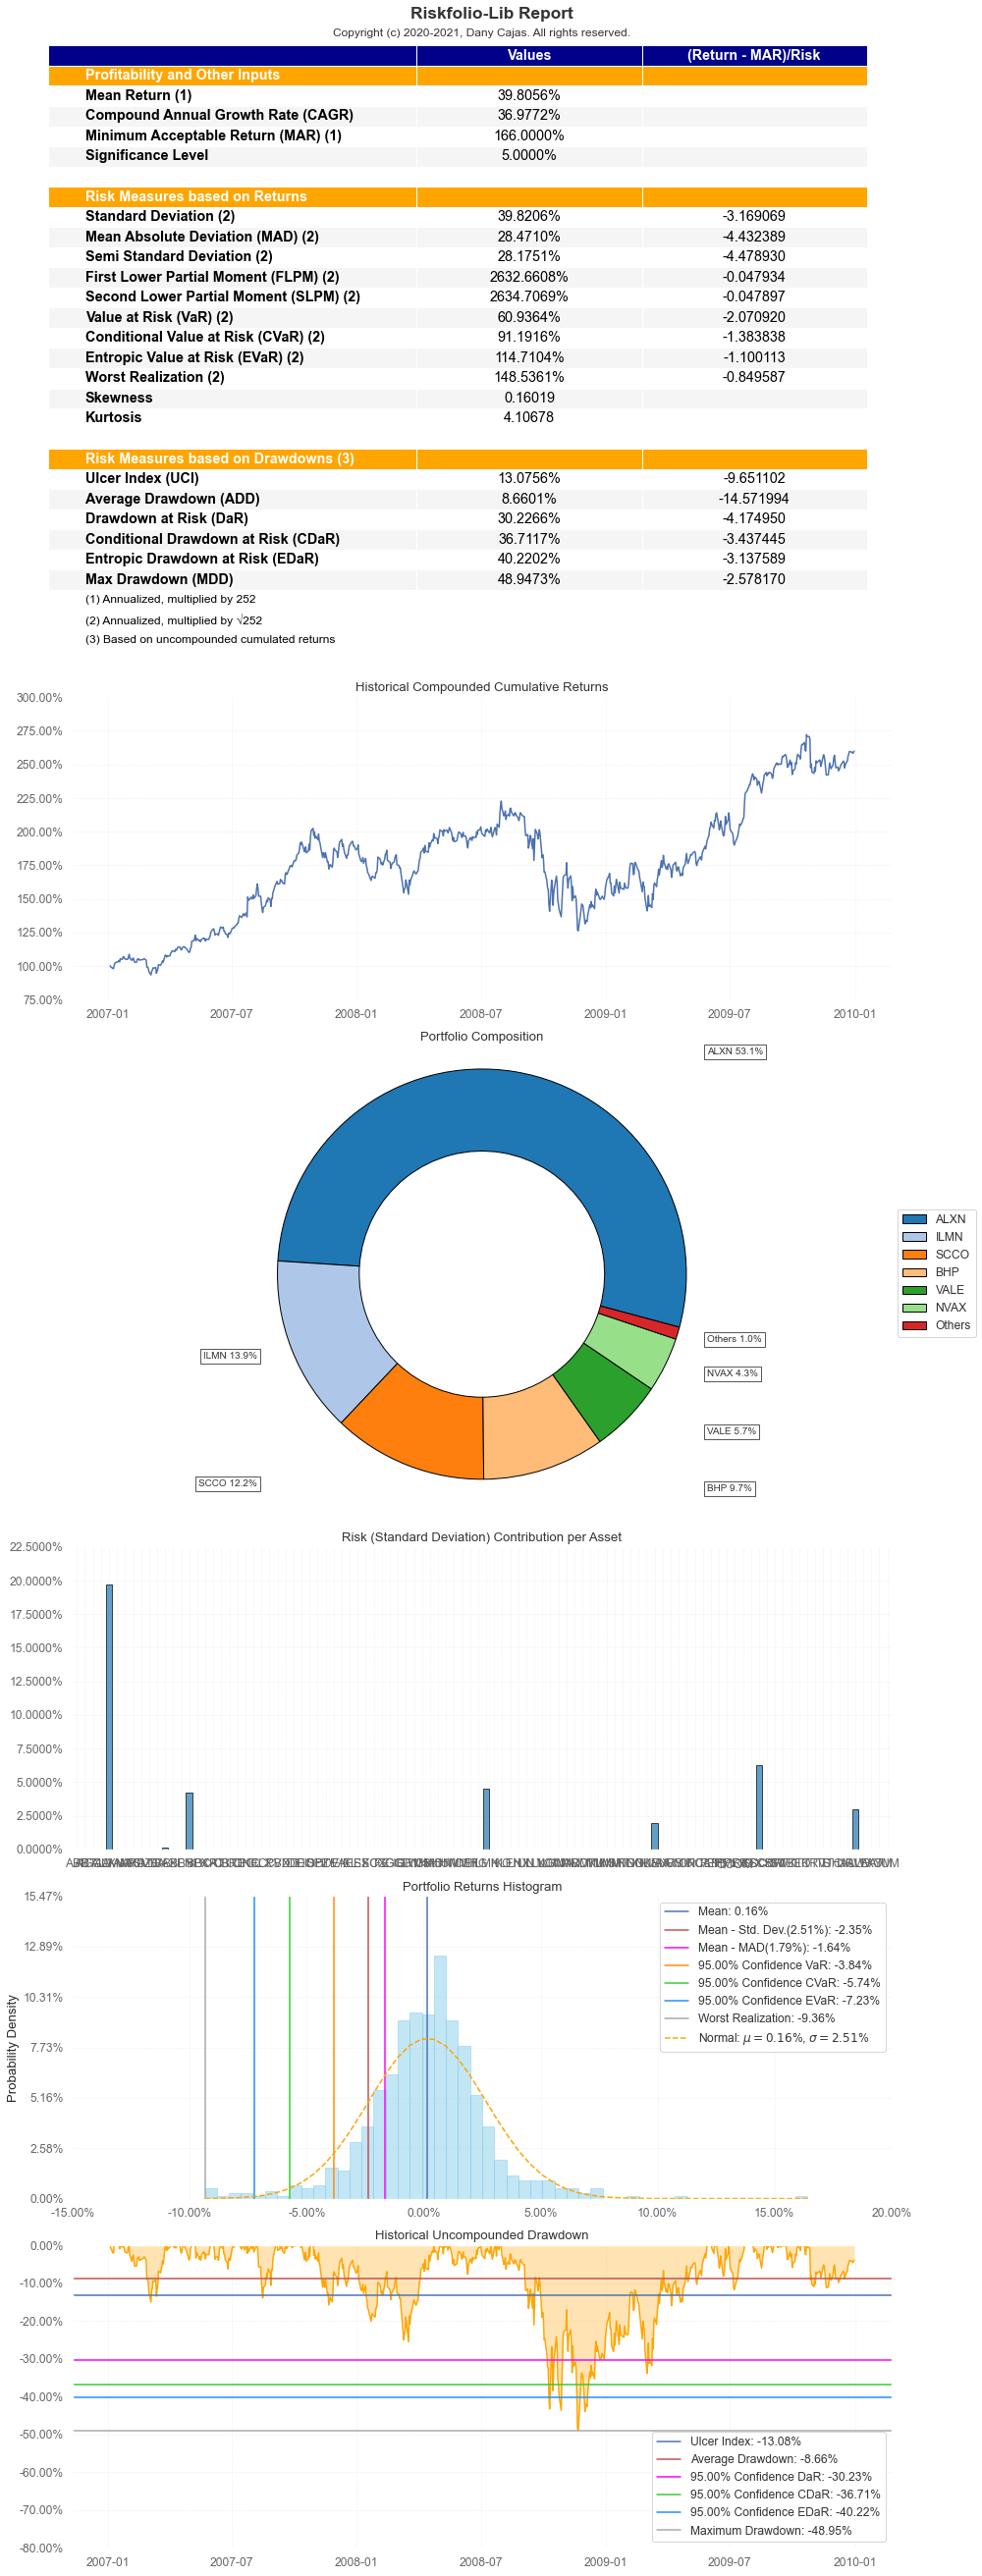

In [78]:
#CAPM_Weights = CAPM_Weights.set_index("Name")
#ax_report = rp.jupyter_report(port_diff, w=CAPM_Weights, rm='MV', rf=1.66, t_factor=21)
ax_report = rp.jupyter_report(port_diff, w=CAPM_Weights, rm='MV', rf=1.66)

\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\riskfolio\RiskFunctions.py:348: RuntimeWarning: overflow encountered in exp
  value = np.mean(np.exp(-1 / z * a), axis=0)
\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\riskfolio\RiskFunctions.py:348: RuntimeWarning: overflow encountered in exp
  value = np.mean(np.exp(-1 / z * a), axis=0)
\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\riskfolio\RiskFunctions.py:348: RuntimeWarning: overflow encountered in exp
  value = np.mean(np.exp(-1 / z * a), axis=0)


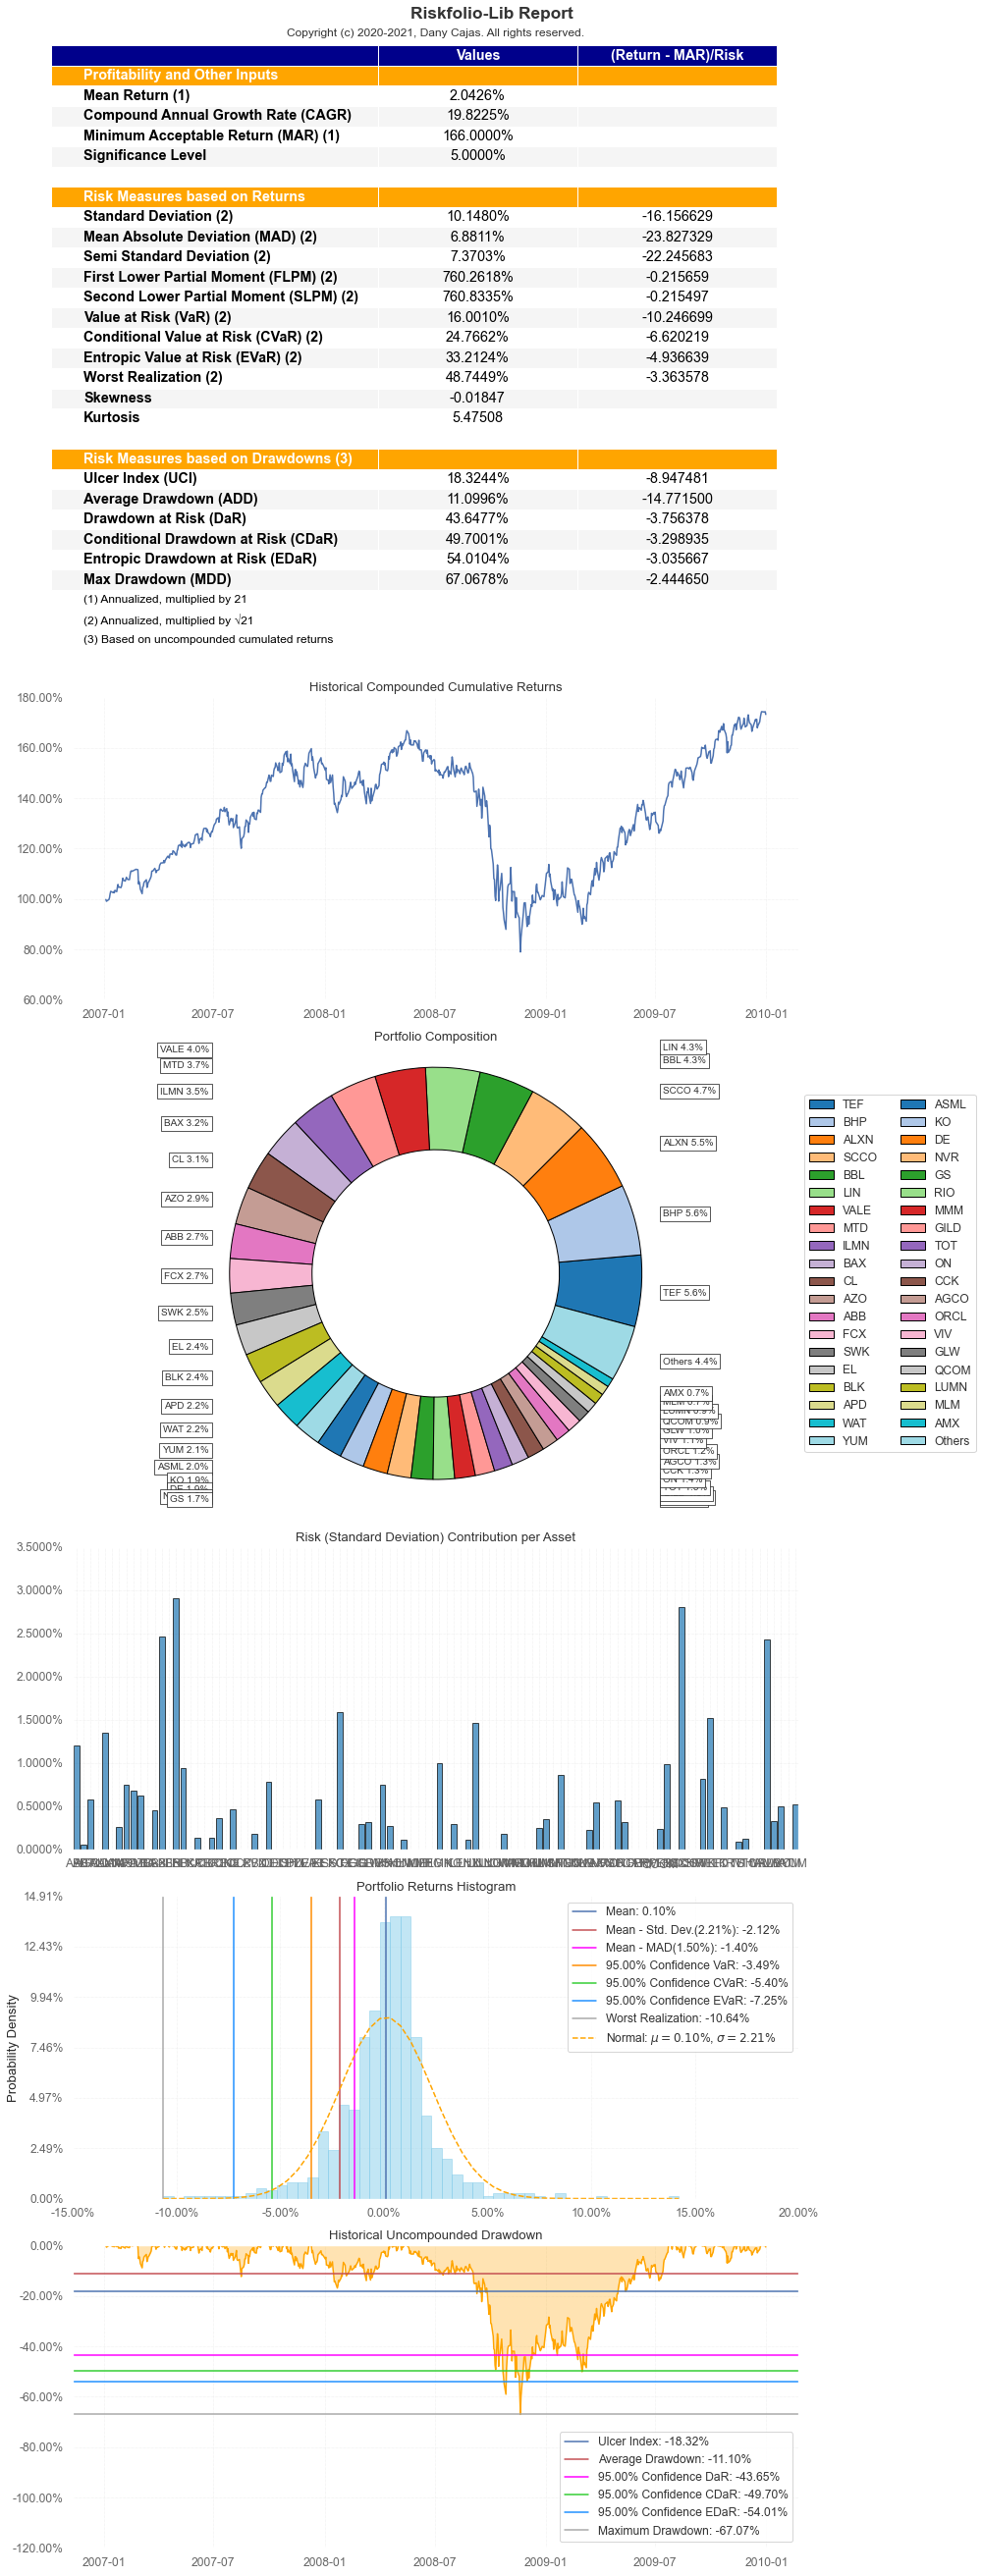

In [76]:
#F3_Weights = F3_Weights.set_index("Name")
#print(F3_Weights)
#F3_Weights =F3_Weights.drop(['index'], axis=1)
ax_report = rp.jupyter_report(port_diff, w=F3_Weights, rm='MV', rf=1.66, t_factor=21)

\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\riskfolio\RiskFunctions.py:348: RuntimeWarning: overflow encountered in exp
  value = np.mean(np.exp(-1 / z * a), axis=0)
\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\riskfolio\RiskFunctions.py:348: RuntimeWarning: overflow encountered in exp
  value = np.mean(np.exp(-1 / z * a), axis=0)
\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\riskfolio\RiskFunctions.py:348: RuntimeWarning: overflow encountered in exp
  value = np.mean(np.exp(-1 / z * a), axis=0)


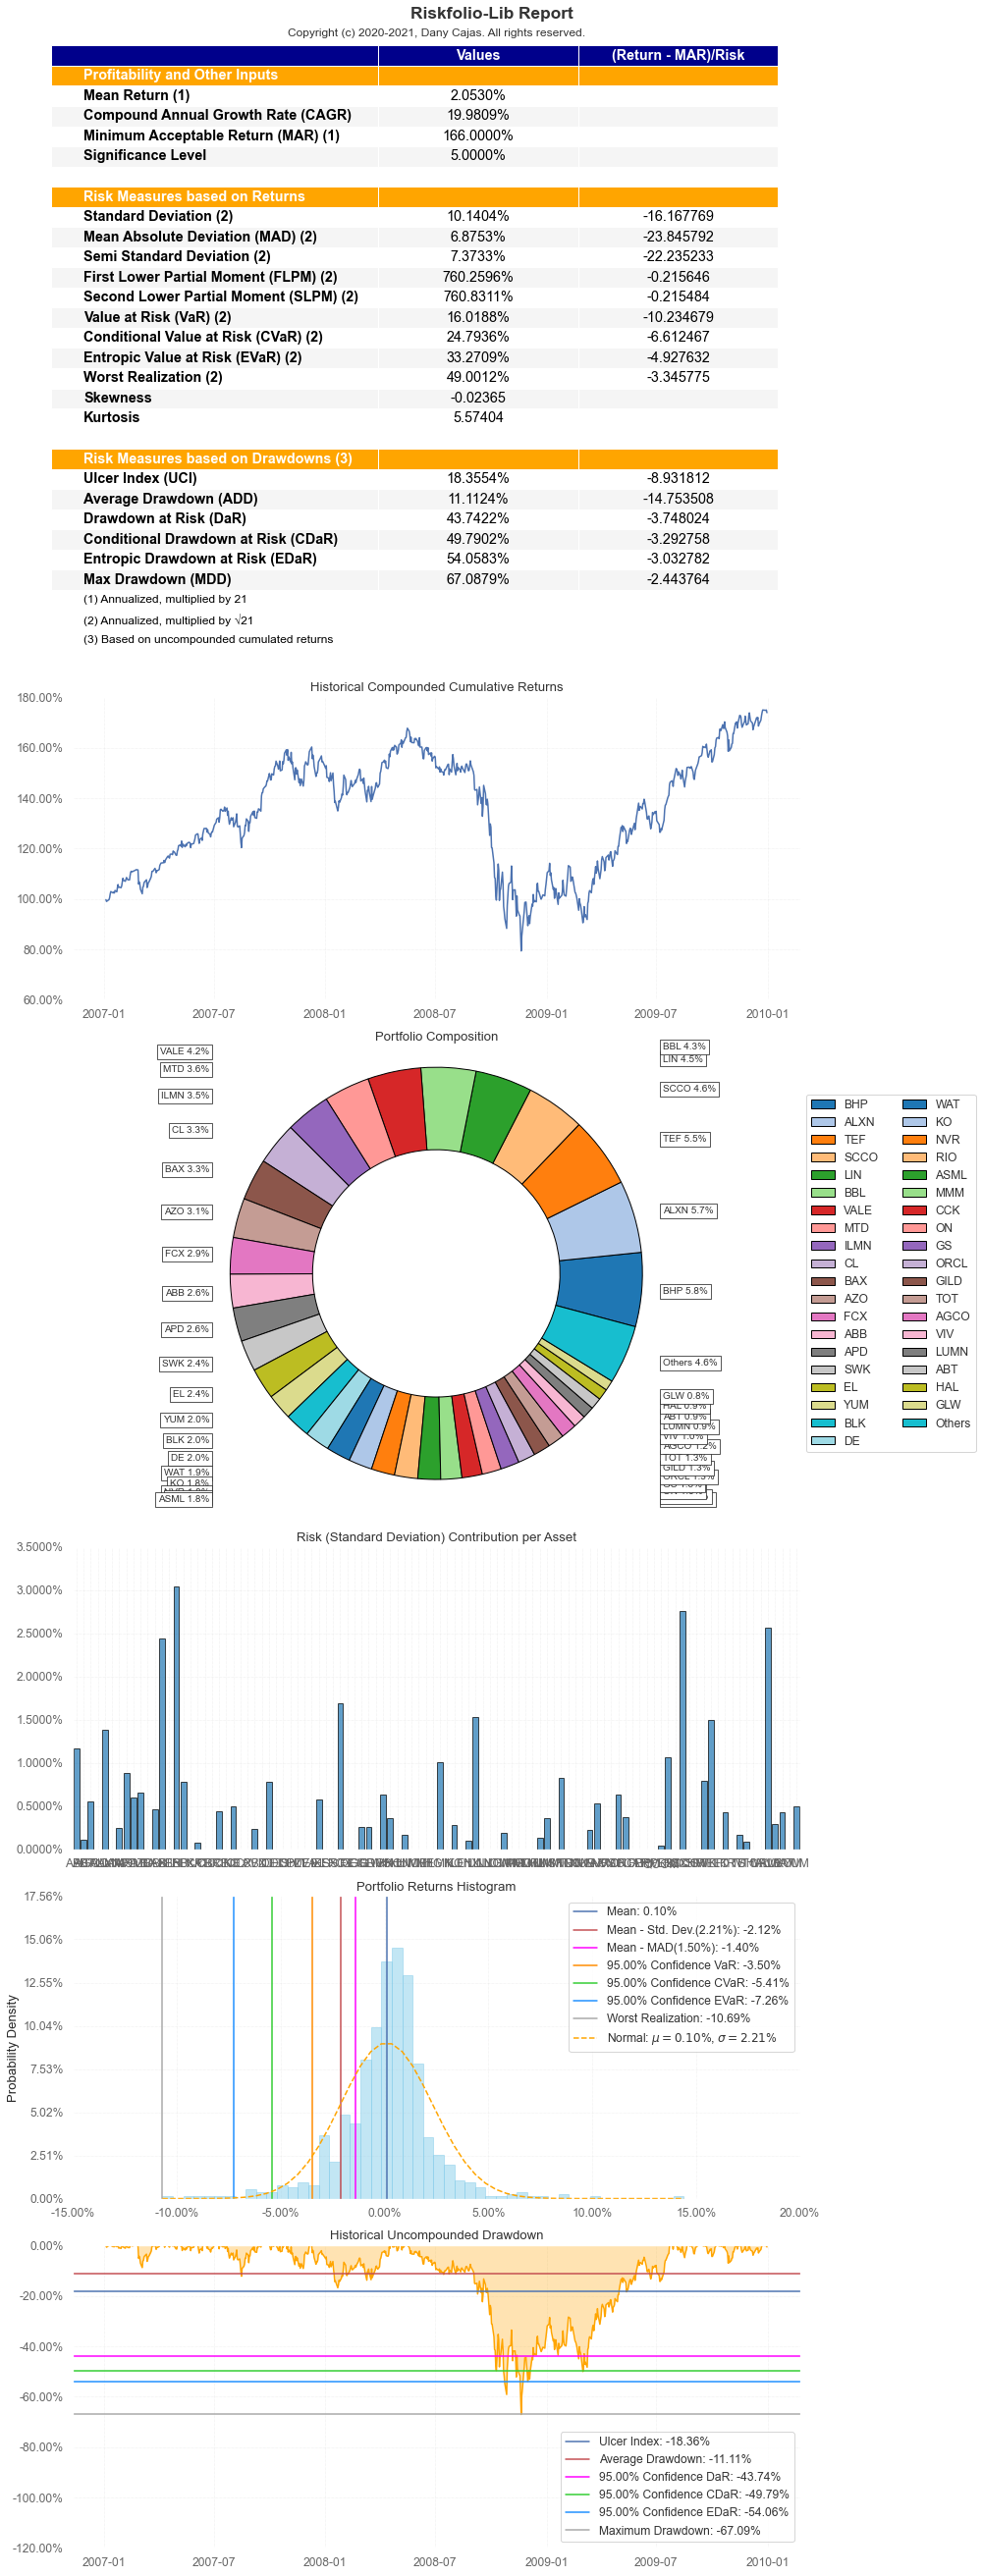

In [74]:
#F5_Weights = F5_Weights.set_index("Name")
ax_report = rp.jupyter_report(port_diff, w=F5_Weights, rm='MV', rf=1.66, t_factor=21)

\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\riskfolio\RiskFunctions.py:348: RuntimeWarning: overflow encountered in exp
  value = np.mean(np.exp(-1 / z * a), axis=0)
\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\riskfolio\RiskFunctions.py:348: RuntimeWarning: overflow encountered in exp
  value = np.mean(np.exp(-1 / z * a), axis=0)
\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\riskfolio\RiskFunctions.py:348: RuntimeWarning: overflow encountered in exp
  value = np.mean(np.exp(-1 / z * a), axis=0)


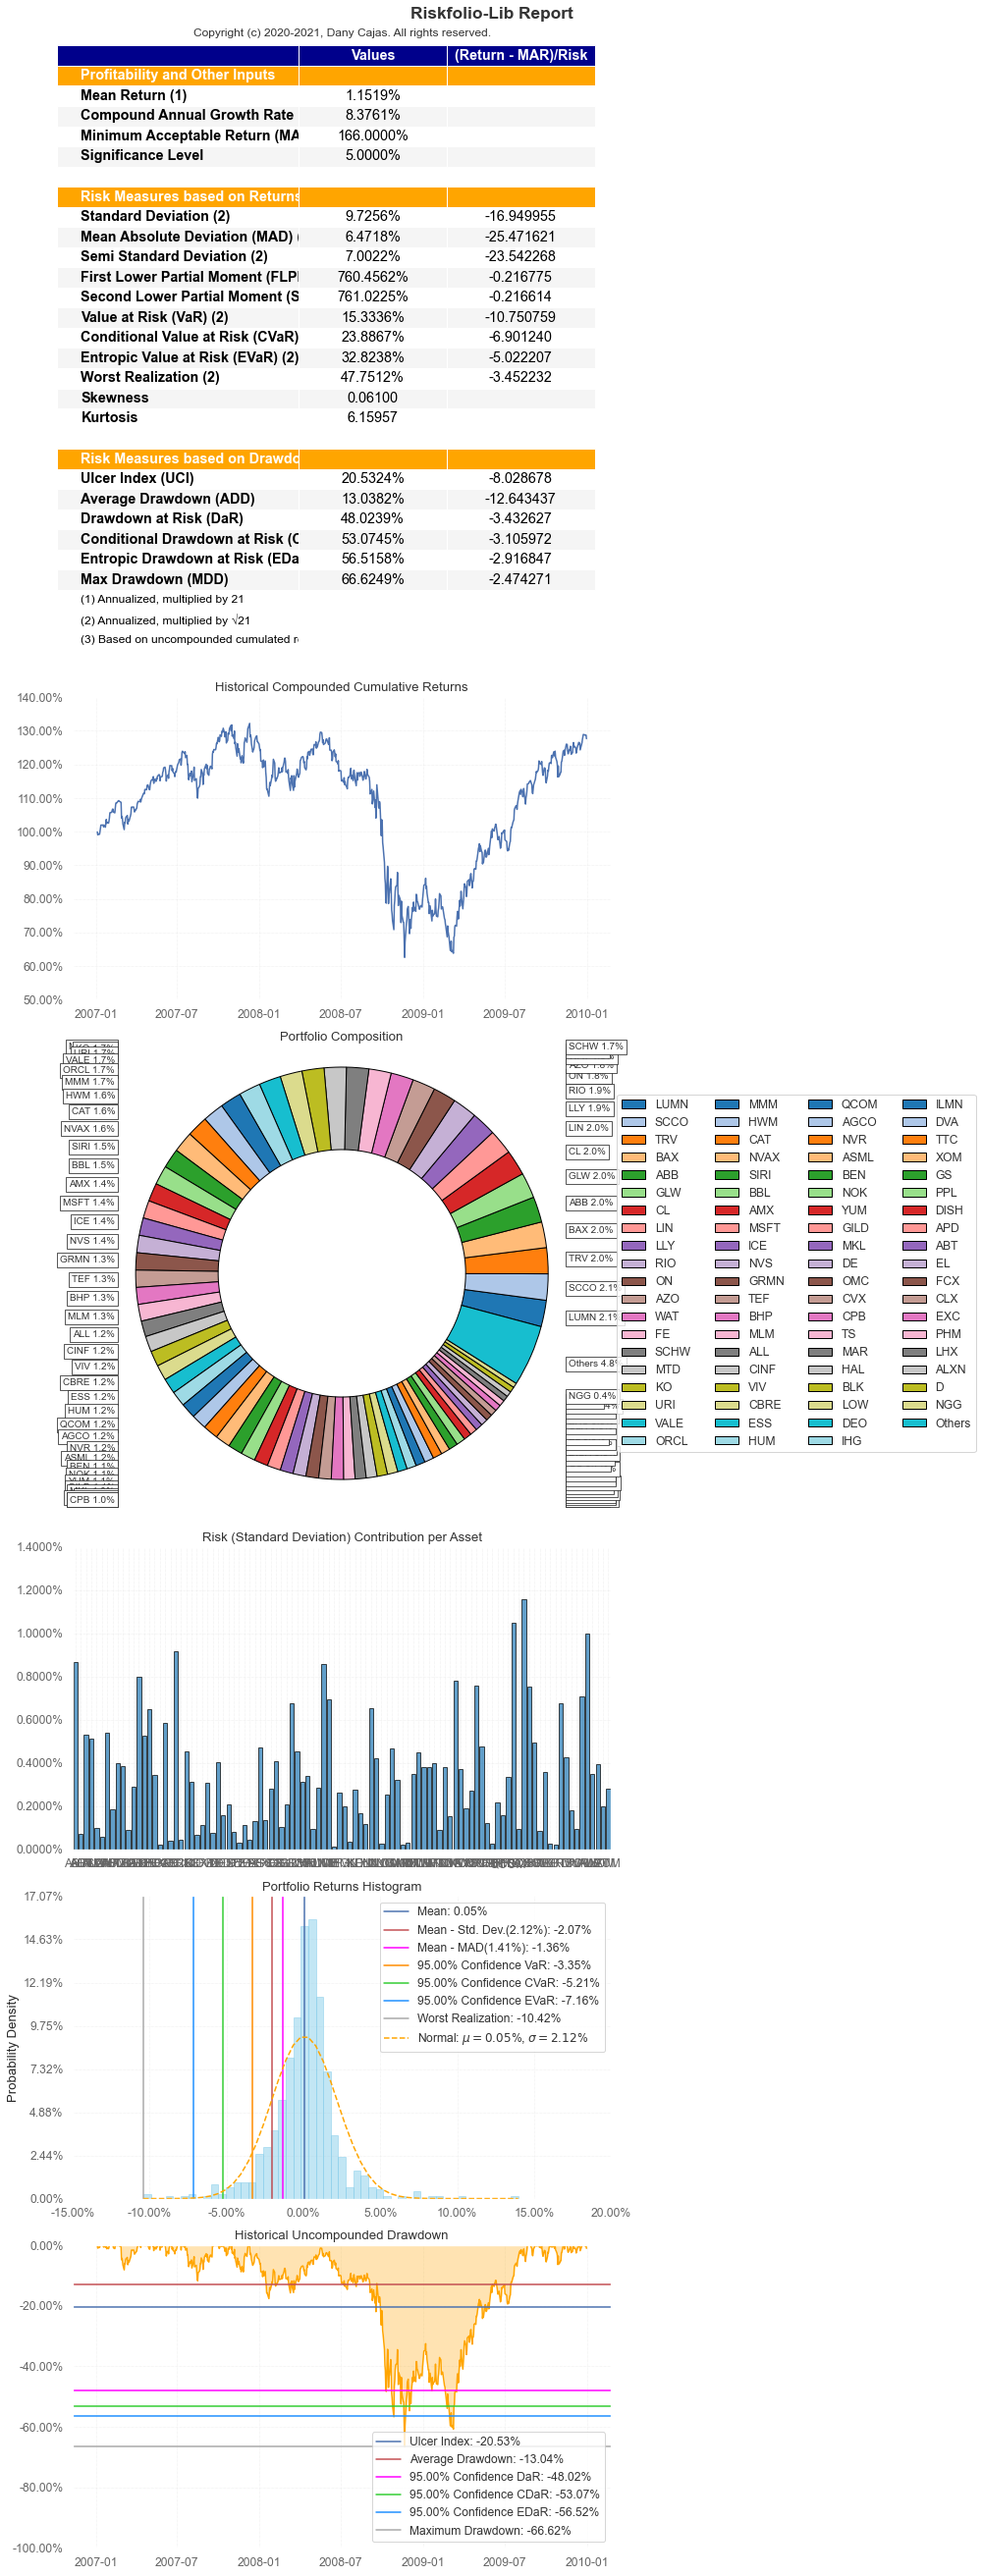

In [75]:
#MC_Weights = MC_Weights.set_index("Name")
ax_report = rp.jupyter_report(port_diff, w=MC_Weights, rm='MV', rf=1.66, t_factor=21)